# Virtual bidding in NYISO's markets


In this lab, we will implement a simple virtual trading strategy in New York
ISO's electricity markets. The goal is to maximize profits. We shall train our
model on price data from one year, and implement the strategy on the data from
the next year. How much can you earn with a certain daily budget? Say \$250K?

We will present a trading strategy. You are welcome to try other strategies and compare the gains over multiple runs.

Let's start with customary imports.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import choice
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pickle

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## Load the day-ahead and real-time prices from 11 zones in New York.

The day-ahead prices are defined every hour. The real-time market runs every 5 minutes. For each zone, an average of
these prices over an hour is published.

Store the list of zones in the variable 'listOfZones'. Also, store the number of options
as the number of zones times the 24 hours available for trading. Finally create another
list containing the option names (zone + hour).

In [2]:
listOfZones = ['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL', 'LONGIL', 'MHK VL',
               'MILLWD', 'N.Y.C.', 'NORTH', 'WEST']

nOptions = len(listOfZones) * 24
optionNames = [zone + "_Hour_" + str(t) for zone in listOfZones for t in range(24)]


## Parse the files with DA and RT prices along with DA load forecast.

Define a function that parses three files containing DA and RT prices, along with DA load predictions from a year from all different zones in the list defined before. This function will be used for to both load the data for training the classifiers and testing them. This function has 3 outputs: they are DA prices, difference between DA and RT prices, and finally DA load predictions. The outputs are pandas data frames whose columns are the options, and rows are the days in the year.

In [3]:
def loadNYISOData(year):

    # Open the relevant files for DA prices, RT prices, DA load.

    dfPriceDA = pd.read_csv("DAM_NYISO_Zonal_LBMP_" + str(year) + ".csv")
    dfPriceRT = pd.read_csv("RTM_NYISO_Zonal_LBMP_" + str(year) + ".csv")
    dfLoadDA = pd.read_csv("DAM_NYISO_LoadForecast_" + str(year) + ".csv")

    # Collect the DA and RT prices from each zone from each hour and create a pandas list.
    # The data should have prices and loads from all days of a year, where each day
    # contributes 24 rows, corresponding to each hour.

    priceDA = pd.DataFrame({zone: (dfPriceDA.loc[dfPriceDA['Zone Name'] == zone,
                                                 'DAM Zonal LBMP']).values
                             for zone in listOfZones})
    priceRT = pd.DataFrame({zone: (dfPriceRT.loc[dfPriceRT['Zone Name'] == zone,
                                                 'TWI Zonal LBMP']).values
                             for zone in listOfZones})
    loadDA = pd.DataFrame({zone: (dfLoadDA.loc[dfLoadDA['Zone Name'] == zone,
                                               'DAM Forecast Load']).values
                            for zone in listOfZones})

    numberOfDays = int(len(priceDA.index)/24)

    # Compute the price differences between DA and RT prices for all options on
    # all days of the year. Store it as a pandas data frame where the 24 rows for
    # each day is flattened into one row. This operation essentially allows us to
    # independently think of each zone in each hour as a separate option. Also,
    # reshape the prices for the DA market in the same manner.

    priceDART = pd.DataFrame([priceRT.sub(priceDA).loc[day * 24:
                                                              (day + 1) * 24 - 1,
                              listOfZones].values.flatten()
                              for day in range(numberOfDays)],
                             columns=optionNames)

    priceDA = pd.DataFrame([priceDA.loc[day * 24: (day + 1) * 24 - 1,
                            listOfZones].values.flatten()
                            for day in range(numberOfDays)],
                           columns=optionNames)

    return priceDA, priceDART, loadDA


## Create a function that creates the inputs for training a classifier

Create a function that takes the price and load data and creates two arrays
'X' and 'Y'. Essentially, the rows of 'X' contains all information relevant to
 predicting the sign of the price difference on the various options on the next day.
 It takes as an input, three pandas frames corresponding to the DA prices, price
 differences, and the DA load predictions, and produces three outputs:
 the arrays 'X', 'Y', and the range of days from the year that were used to
 create the data 'X' and 'Y'. This function will be used to both train and
 test classifiers.

In [4]:
def createClassifierIO(priceDA, priceDART, loadDA):

    # Define how many past days of prices to use for classification.

    pastPrices = range(1, 3)

    # Define how many past days of load predictions to use for classification.

    pastLoad = range(1, 3)

    # Define a date range within the year to create the arrays 'X' and 'Y' in a way
    # that past price and load data for the first day is within the date range in the
    # pandas frames passed as inputs.

    rangeOfDays = range(3, len(priceDA.index))

    # 'X' will contain three sets of variables:
    #   1. the DA prices from past days in the list 'pastDays',
    #   2. the differences between DA and RT prices from the same past days,
    #   3. the load predictions from past days in the list 'pastLoad'

    X = [np.concatenate((
        priceDA.loc[[(day - h) for h in pastPrices]].values.flatten(),
        priceDART.loc[[(day - h) for h in pastPrices]].values.flatten(),
        loadDA.loc[[(day - h) for h in pastLoad]].values.flatten()
    )) for day in rangeOfDays]

    # Scale the array 'X' to make its data zero mean and unit variance.
    X = StandardScaler().fit_transform(X)

    # 'Y' will contain zeros and ones, where a one indicates that the price in DA is
    # higher than in RT for a particular option. Recall that an option corresponds to
    # a zone at a particular hour of the day.

    Y = np.array([(priceDART.loc[day].values > 0).astype(int)
                  for day in rangeOfDays])

    # Return the arrays 'X' and 'Y', and finally the range of days from the year that
    # will be utilized for training or testing the classifier.
    return X, Y, rangeOfDays

## Design the training module.
 The training module utilizes a year's worth of data to determine the following for
 each option, i.e., for each zone for each hour of the day:
   1. Classifiers that predict the sign of the difference between DA and RT prices.
   2. Statistics of the mean of the price difference.
   3. A quantile of the day-ahead prices that we will use as our bid for each option.
 You will either train the classifiers here or load them from the folder './Classifiers'.
 Storing the classifiers from time to time allows you to only vary the bidding strategy
 and observe the annual reward rather than having to train the classifiers every time.
 
### Define and train the classifiers or load pre-trained classifiers.

In [5]:
classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.


    classifiers = [MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=200)
                   for _ in range(nOptions)]

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    print("All training variables were loaded successfully...\n")

Starting training module...

Loaded hourly prices from 2015 for 365 days.
Classifier trained for option CAPITL_Hour_0
Classifier trained for option CAPITL_Hour_1
Classifier trained for option CAPITL_Hour_2
Classifier trained for option CAPITL_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CAPITL_Hour_4
Classifier trained for option CAPITL_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CAPITL_Hour_6
Classifier trained for option CAPITL_Hour_7
Classifier trained for option CAPITL_Hour_8
Classifier trained for option CAPITL_Hour_9
Classifier trained for option CAPITL_Hour_10
Classifier trained for option CAPITL_Hour_11
Classifier trained for option CAPITL_Hour_12
Classifier trained for option CAPITL_Hour_13
Classifier trained for option CAPITL_Hour_14
Classifier trained for option CAPITL_Hour_15
Classifier trained for option CAPITL_Hour_16
Classifier trained for option CAPITL_Hour_17
Classifier trained for option CAPITL_Hour_18
Classifier trained for option CAPITL_Hour_19
Classifier trained for option CAPITL_Hour_20
Classifier trained for option CAPITL_Hour_21
Classifier trained for option CAPITL_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CAPITL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CENTRL_Hour_0
Classifier trained for option CENTRL_Hour_1
Classifier trained for option CENTRL_Hour_2
Classifier trained for option CENTRL_Hour_3
Classifier trained for option CENTRL_Hour_4
Classifier trained for option CENTRL_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CENTRL_Hour_6
Classifier trained for option CENTRL_Hour_7
Classifier trained for option CENTRL_Hour_8
Classifier trained for option CENTRL_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CENTRL_Hour_10
Classifier trained for option CENTRL_Hour_11
Classifier trained for option CENTRL_Hour_12
Classifier trained for option CENTRL_Hour_13
Classifier trained for option CENTRL_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CENTRL_Hour_15
Classifier trained for option CENTRL_Hour_16
Classifier trained for option CENTRL_Hour_17
Classifier trained for option CENTRL_Hour_18
Classifier trained for option CENTRL_Hour_19
Classifier trained for option CENTRL_Hour_20
Classifier trained for option CENTRL_Hour_21
Classifier trained for option CENTRL_Hour_22
Classifier trained for option CENTRL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_0
Classifier trained for option DUNWOD_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_2
Classifier trained for option DUNWOD_Hour_3
Classifier trained for option DUNWOD_Hour_4
Classifier trained for option DUNWOD_Hour_5
Classifier trained for option DUNWOD_Hour_6
Classifier trained for option DUNWOD_Hour_7
Classifier trained for option DUNWOD_Hour_8
Classifier trained for option DUNWOD_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_10
Classifier trained for option DUNWOD_Hour_11
Classifier trained for option DUNWOD_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_14
Classifier trained for option DUNWOD_Hour_15
Classifier trained for option DUNWOD_Hour_16
Classifier trained for option DUNWOD_Hour_17
Classifier trained for option DUNWOD_Hour_18
Classifier trained for option DUNWOD_Hour_19
Classifier trained for option DUNWOD_Hour_20
Classifier trained for option DUNWOD_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_22
Classifier trained for option DUNWOD_Hour_23
Classifier trained for option GENESE_Hour_0
Classifier trained for option GENESE_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_2
Classifier trained for option GENESE_Hour_3
Classifier trained for option GENESE_Hour_4
Classifier trained for option GENESE_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_6
Classifier trained for option GENESE_Hour_7
Classifier trained for option GENESE_Hour_8
Classifier trained for option GENESE_Hour_9
Classifier trained for option GENESE_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_11
Classifier trained for option GENESE_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_13
Classifier trained for option GENESE_Hour_14
Classifier trained for option GENESE_Hour_15
Classifier trained for option GENESE_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_17
Classifier trained for option GENESE_Hour_18
Classifier trained for option GENESE_Hour_19
Classifier trained for option GENESE_Hour_20
Classifier trained for option GENESE_Hour_21
Classifier trained for option GENESE_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_23
Classifier trained for option HUD VL_Hour_0
Classifier trained for option HUD VL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_2
Classifier trained for option HUD VL_Hour_3
Classifier trained for option HUD VL_Hour_4
Classifier trained for option HUD VL_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_6
Classifier trained for option HUD VL_Hour_7
Classifier trained for option HUD VL_Hour_8
Classifier trained for option HUD VL_Hour_9
Classifier trained for option HUD VL_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_11
Classifier trained for option HUD VL_Hour_12
Classifier trained for option HUD VL_Hour_13
Classifier trained for option HUD VL_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_16
Classifier trained for option HUD VL_Hour_17
Classifier trained for option HUD VL_Hour_18
Classifier trained for option HUD VL_Hour_19
Classifier trained for option HUD VL_Hour_20
Classifier trained for option HUD VL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_22
Classifier trained for option HUD VL_Hour_23
Classifier trained for option LONGIL_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_1
Classifier trained for option LONGIL_Hour_2
Classifier trained for option LONGIL_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_4
Classifier trained for option LONGIL_Hour_5
Classifier trained for option LONGIL_Hour_6
Classifier trained for option LONGIL_Hour_7
Classifier trained for option LONGIL_Hour_8
Classifier trained for option LONGIL_Hour_9
Classifier trained for option LONGIL_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_11
Classifier trained for option LONGIL_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_13
Classifier trained for option LONGIL_Hour_14
Classifier trained for option LONGIL_Hour_15
Classifier trained for option LONGIL_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_17
Classifier trained for option LONGIL_Hour_18
Classifier trained for option LONGIL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_20
Classifier trained for option LONGIL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_22
Classifier trained for option LONGIL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_0
Classifier trained for option MHK VL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_2
Classifier trained for option MHK VL_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_4
Classifier trained for option MHK VL_Hour_5
Classifier trained for option MHK VL_Hour_6
Classifier trained for option MHK VL_Hour_7
Classifier trained for option MHK VL_Hour_8
Classifier trained for option MHK VL_Hour_9
Classifier trained for option MHK VL_Hour_10
Classifier trained for option MHK VL_Hour_11
Classifier trained for option MHK VL_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_13
Classifier trained for option MHK VL_Hour_14
Classifier trained for option MHK VL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_16
Classifier trained for option MHK VL_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_18
Classifier trained for option MHK VL_Hour_19
Classifier trained for option MHK VL_Hour_20
Classifier trained for option MHK VL_Hour_21
Classifier trained for option MHK VL_Hour_22
Classifier trained for option MHK VL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_0
Classifier trained for option MILLWD_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_3
Classifier trained for option MILLWD_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_5
Classifier trained for option MILLWD_Hour_6
Classifier trained for option MILLWD_Hour_7
Classifier trained for option MILLWD_Hour_8
Classifier trained for option MILLWD_Hour_9
Classifier trained for option MILLWD_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_11
Classifier trained for option MILLWD_Hour_12
Classifier trained for option MILLWD_Hour_13
Classifier trained for option MILLWD_Hour_14
Classifier trained for option MILLWD_Hour_15
Classifier trained for option MILLWD_Hour_16
Classifier trained for option MILLWD_Hour_17
Classifier trained for option MILLWD_Hour_18
Classifier trained for option MILLWD_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_20
Classifier trained for option MILLWD_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_22
Classifier trained for option MILLWD_Hour_23
Classifier trained for option N.Y.C._Hour_0
Classifier trained for option N.Y.C._Hour_1
Classifier trained for option N.Y.C._Hour_2
Classifier trained for option N.Y.C._Hour_3
Classifier trained for option N.Y.C._Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_6
Classifier trained for option N.Y.C._Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_9
Classifier trained for option N.Y.C._Hour_10
Classifier trained for option N.Y.C._Hour_11
Classifier trained for option N.Y.C._Hour_12
Classifier trained for option N.Y.C._Hour_13
Classifier trained for option N.Y.C._Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_16
Classifier trained for option N.Y.C._Hour_17
Classifier trained for option N.Y.C._Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_19
Classifier trained for option N.Y.C._Hour_20
Classifier trained for option N.Y.C._Hour_21
Classifier trained for option N.Y.C._Hour_22
Classifier trained for option N.Y.C._Hour_23
Classifier trained for option NORTH_Hour_0
Classifier trained for option NORTH_Hour_1
Classifier trained for option NORTH_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_3
Classifier trained for option NORTH_Hour_4
Classifier trained for option NORTH_Hour_5
Classifier trained for option NORTH_Hour_6
Classifier trained for option NORTH_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_8
Classifier trained for option NORTH_Hour_9
Classifier trained for option NORTH_Hour_10
Classifier trained for option NORTH_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_13
Classifier trained for option NORTH_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_15
Classifier trained for option NORTH_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_17
Classifier trained for option NORTH_Hour_18
Classifier trained for option NORTH_Hour_19
Classifier trained for option NORTH_Hour_20
Classifier trained for option NORTH_Hour_21
Classifier trained for option NORTH_Hour_22
Classifier trained for option NORTH_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_0
Classifier trained for option WEST_Hour_1
Classifier trained for option WEST_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_3
Classifier trained for option WEST_Hour_4
Classifier trained for option WEST_Hour_5
Classifier trained for option WEST_Hour_6
Classifier trained for option WEST_Hour_7
Classifier trained for option WEST_Hour_8
Classifier trained for option WEST_Hour_9
Classifier trained for option WEST_Hour_10
Classifier trained for option WEST_Hour_11
Classifier trained for option WEST_Hour_12
Classifier trained for option WEST_Hour_13
Classifier trained for option WEST_Hour_14
Classifier trained for option WEST_Hour_15
Classifier trained for option WEST_Hour_16
Classifier trained for option WEST_Hour_17
Classifier trained for option WEST_Hour_18
Classifier trained for option WEST_Hour_19
Classifier trained for option WEST_Hour_20
Classifier trained for option WEST_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_22
Classifier trained for option WEST_Hour_23

Overall training accuracy = 99.70 percent.


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Test the classifier's accuracy on test data.

In [6]:
# First, load the test data from NYISO for the year 2016. Again, utilize our function
# named 'loadNYISOData'.

print("Starting the testing module...\n")
testPriceDA, testPriceDART, testLoadDA = loadNYISOData(2016)

# Create the data for the classifier using the function 'createClassifierIO'.
testX, testY, rangeOfDays = createClassifierIO(testPriceDA, testPriceDART, testLoadDA)

# The next step is not useful for implementing the trading strategy, but quickly check how accurate
# your trained classifiers are for the test data. Training accuracy is not always indicative of
# test accuracy.

testingAccuracy = [classifiers[ii].score(testX, testY[:, ii]) for ii in range(nOptions)]
print("Test Accuracy Stats: Min = %.2f%%, Avg = %.2f%%, Max = %.2f%%" %
      (100 * np.min(testingAccuracy),
       100 * np.mean(testingAccuracy),
       100 * np.max(testingAccuracy)))

# Utilize the classifiers to predict the sign of DA - RT prices for each day in 'rangeOfDays' for
# the test data. Store the result in a pandas data frame with columns as the option names and the
# day in year as index.
predictedY = pd.DataFrame(np.column_stack([classifiers[ii].predict(testX) for ii in range(nOptions)]),
                          columns=optionNames, index=rangeOfDays)

Starting the testing module...

Test Accuracy Stats: Min = 31.96%, Avg = 58.74%, Max = 68.04%


## Design and implement the trading strategy. 

We define a fairly simple trading strategy. Define a total budget that you are willing to spend in the DA market. Recall that we only invest in
options where we buy at the DA market and sell at the RT market. When your bid for one unit of an option
clears in the DA market, you have to pay the DA price for that option. There are two possibilities:
  1. Your bid clears: Therefore, your offer price was higher than the DA price.
  2. Your bid does not clear: Then, the DA price was higher than your bid.
In both these cases, the maximum you have to pay is your bid. Therefore, we will enforce that your bids
across all options in a day does not exceed your total budget.
Keep track of how rewards grow (or fall) through the year
as you utilize your strategy. Also, keep track of how much rewards you get from each option. We shall
visualize these results after implementing the trading strategy over the NYISO data for 2016.

Choose the bid prices as a suitable quantile of the historical DA prices. The higher the quantile, the
better your chances are that your bid will be cleared. However, a higher quantile also indicates that
you are budgeting more money for each option, and hence, you will buy fewer options.

In [7]:
dailyBudget = 250000
quantileOffer =0.8

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Day 3: Reward (in $) = -103,835
Day 4: Reward (in $) = 1,566,130
Day 5: Reward (in $) = 27,610
Day 6: Reward (in $) = -22,793
Day 7: Reward (in $) = -3,892
Day 8: Reward (in $) = -1,738
Day 9: Reward (in $) = -40,295
Day 10: Reward (in $) = -105,750
Day 11: Reward (in $) = -124,366
Day 12: Reward (in $) = -71,800
Day 13: Reward (in $) = -51,301
Day 14: Reward (in $) = -40,373
Day 15: Reward (in $) = -6,423
Day 16: Reward (in $) = 17,364
Day 17: Reward (in $) = -62,208
Day 18: Reward (in $) = -18,996
Day 19: Reward (in $) = 24,486
Day 20: Reward (in $) = -622
Day 21: Reward (in $) = 19,678
Day 22: Reward (in $) = 86,392
Day 23: Reward (in $) = 31,674
Day 24: Reward (in $) = -72,911
Day 25: Reward (in $) = -39,606
Day 26: Reward (in $) = -37,525
Day 27: Reward (in $) = -11,467
Day 28: Reward (in $) = -11,661
Day 29: Reward (in $) = -24,888
Day 30: Reward (in $) = -65,665
Day 31: Reward (in $) = -47,461
Day 32: Reward (in $) = -7,944
Day 33: Reward (in $) = -184,786
Day 34: Reward (in $) 

Day 260: Reward (in $) = -16,745
Day 261: Reward (in $) = 29,260
Day 262: Reward (in $) = 3,610
Day 263: Reward (in $) = -65,791
Day 264: Reward (in $) = -35,290
Day 265: Reward (in $) = -57,851
Day 266: Reward (in $) = -71,154
Day 267: Reward (in $) = -16,377
Day 268: Reward (in $) = -24,490
Day 269: Reward (in $) = -66,758
Day 270: Reward (in $) = -70,051
Day 271: Reward (in $) = -7,962
Day 272: Reward (in $) = -37,819
Day 273: Reward (in $) = -32,428
Day 274: Reward (in $) = 12,166
Day 275: Reward (in $) = 25,702
Day 276: Reward (in $) = 38,227
Day 277: Reward (in $) = 138,378
Day 278: Reward (in $) = 102,339
Day 279: Reward (in $) = 31,519
Day 280: Reward (in $) = 16,631
Day 281: Reward (in $) = -8,938
Day 282: Reward (in $) = -323
Day 283: Reward (in $) = -1,442
Day 284: Reward (in $) = -30,104
Day 285: Reward (in $) = 18,045
Day 286: Reward (in $) = -55,207
Day 287: Reward (in $) = -66,702
Day 288: Reward (in $) = 11,347
Day 289: Reward (in $) = 21,068
Day 290: Reward (in $) = 5,

### Task1:  Visualize the rewards (25 points)

We would like to plot the cumulative reward over the year 2016. By cumulative reward on a particular date, we mean the total reward from the start of the year till that date.

Also, plot a heat map of the returns from each option. 

#### Fill in the missing lines below.

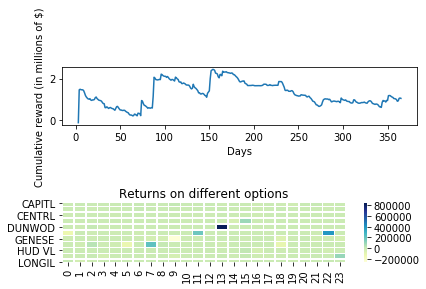

In [8]:
# Plot the cumulative reward over the year 2016. Also, plot a heat map of the returns from
# each option.

fig, axs = plt.subplots(2, 1, tight_layout=True)
axs = axs.ravel()



## Enter code here where you plot in axs[0].

lists = sorted(cumulativeReward.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
axs[0].plot(x, y)
axs[0].set_ylabel("Cumulative reward (in millions of $)")
axs[0].set_xlabel("Days")





axs[1] = sns.heatmap(np.reshape(list(optionReturn.values()), (len(listOfZones), 24)),
                     linewidth=0.5,
                     cmap="YlGnBu")
axs[1].set_yticklabels(listOfZones, rotation=0)
axs[1].set_xticklabels(range(24), rotation=90)
axs[1].set_title('Returns on different options')
plt.show()


### Task 2: Choosing a classifier (25 points)

We used a multilayer perceptron classifier. Your task is to try out SVM and logistic regression classifiers, and explore which one leads to more profits. Use the relevant functions from 'sklearn'.

                SVC     Logistic Regression   MLP
                 
Accuracy:     -------- 78.32 ---------          ------ 98.88 --------               ------ 59.06 ----
                        

Profits:        ------3,462,815------        ------3,540,242------         ------3,497,272------
                 

Logistic regression leads to maximum profits and the highest training accuracy rate.


In [9]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.


    classifiers = [SVC() for _ in range(nOptions)]

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    print("All training variables were loaded successfully...\n")

Starting training module...

Loaded hourly prices from 2015 for 365 days.
Classifier trained for option CAPITL_Hour_0
Classifier trained for option CAPITL_Hour_1
Classifier trained for option CAPITL_Hour_2
Classifier trained for option CAPITL_Hour_3
Classifier trained for option CAPITL_Hour_4
Classifier trained for option CAPITL_Hour_5
Classifier trained for option CAPITL_Hour_6
Classifier trained for option CAPITL_Hour_7
Classifier trained for option CAPITL_Hour_8
Classifier trained for option CAPITL_Hour_9
Classifier trained for option CAPITL_Hour_10
Classifier trained for option CAPITL_Hour_11
Classifier trained for option CAPITL_Hour_12
Classifier trained for option CAPITL_Hour_13
Classifier trained for option CAPITL_Hour_14
Classifier trained for option CAPITL_Hour_15
Classifier trained for option CAPITL_Hour_16
Classifier trained for option CAPITL_Hour_17
Classifier trained for option CAPITL_Hour_18
Classifier trained for option CAPITL_Hour_19
Classifier trained for option CAPITL

Classifier trained for option MILLWD_Hour_15
Classifier trained for option MILLWD_Hour_16
Classifier trained for option MILLWD_Hour_17
Classifier trained for option MILLWD_Hour_18
Classifier trained for option MILLWD_Hour_19
Classifier trained for option MILLWD_Hour_20
Classifier trained for option MILLWD_Hour_21
Classifier trained for option MILLWD_Hour_22
Classifier trained for option MILLWD_Hour_23
Classifier trained for option N.Y.C._Hour_0
Classifier trained for option N.Y.C._Hour_1
Classifier trained for option N.Y.C._Hour_2
Classifier trained for option N.Y.C._Hour_3
Classifier trained for option N.Y.C._Hour_4
Classifier trained for option N.Y.C._Hour_5
Classifier trained for option N.Y.C._Hour_6
Classifier trained for option N.Y.C._Hour_7
Classifier trained for option N.Y.C._Hour_8
Classifier trained for option N.Y.C._Hour_9
Classifier trained for option N.Y.C._Hour_10
Classifier trained for option N.Y.C._Hour_11
Classifier trained for option N.Y.C._Hour_12
Classifier trained f

In [10]:
dailyBudget = 250000
quantileOffer =0.8

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Day 3: Reward (in $) = -102,083
Day 4: Reward (in $) = 1,570,814
Day 5: Reward (in $) = 27,040
Day 6: Reward (in $) = -22,919
Day 7: Reward (in $) = -3,116
Day 8: Reward (in $) = -1,954
Day 9: Reward (in $) = -41,292
Day 10: Reward (in $) = -106,491
Day 11: Reward (in $) = -123,025
Day 12: Reward (in $) = -71,558
Day 13: Reward (in $) = -51,708
Day 14: Reward (in $) = -40,684
Day 15: Reward (in $) = -6,613
Day 16: Reward (in $) = 17,100
Day 17: Reward (in $) = -62,272
Day 18: Reward (in $) = -18,476
Day 19: Reward (in $) = 26,062
Day 20: Reward (in $) = -395
Day 21: Reward (in $) = 20,802
Day 22: Reward (in $) = 87,872
Day 23: Reward (in $) = 31,677
Day 24: Reward (in $) = -72,572
Day 25: Reward (in $) = -39,214
Day 26: Reward (in $) = -38,475
Day 27: Reward (in $) = -11,688
Day 28: Reward (in $) = -11,323
Day 29: Reward (in $) = -24,913
Day 30: Reward (in $) = -65,282
Day 31: Reward (in $) = -47,450
Day 32: Reward (in $) = -7,849
Day 33: Reward (in $) = -182,501
Day 34: Reward (in $) 

Day 260: Reward (in $) = -16,727
Day 261: Reward (in $) = 30,185
Day 262: Reward (in $) = 84
Day 263: Reward (in $) = -65,885
Day 264: Reward (in $) = -34,691
Day 265: Reward (in $) = -56,874
Day 266: Reward (in $) = -70,575
Day 267: Reward (in $) = -16,065
Day 268: Reward (in $) = -24,763
Day 269: Reward (in $) = -66,645
Day 270: Reward (in $) = -71,660
Day 271: Reward (in $) = -8,117
Day 272: Reward (in $) = -37,960
Day 273: Reward (in $) = -32,528
Day 274: Reward (in $) = 12,182
Day 275: Reward (in $) = 25,861
Day 276: Reward (in $) = 38,139
Day 277: Reward (in $) = 137,069
Day 278: Reward (in $) = 104,760
Day 279: Reward (in $) = 32,178
Day 280: Reward (in $) = 16,285
Day 281: Reward (in $) = -8,904
Day 282: Reward (in $) = 60
Day 283: Reward (in $) = -1,397
Day 284: Reward (in $) = -28,328
Day 285: Reward (in $) = 18,152
Day 286: Reward (in $) = -54,801
Day 287: Reward (in $) = -66,174
Day 288: Reward (in $) = 11,533
Day 289: Reward (in $) = 21,127
Day 290: Reward (in $) = 6,290
D

In [11]:
classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.


    classifiers = [LogisticRegression() for _ in range(nOptions)]

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    print("All training variables were loaded successfully...\n")

Starting training module...

Loaded hourly prices from 2015 for 365 days.


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_0
Classifier trained for option CAPITL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_9
Classifier trained for option CAPITL_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_12
Classifier trained for option CAPITL_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_16
Classifier trained for option CAPITL_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_20
Classifier trained for option CAPITL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_22
Classifier trained for option CAPITL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_0
Classifier trained for option CENTRL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_3
Classifier trained for option CENTRL_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_7
Classifier trained for option CENTRL_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_7
Classifier trained for option DUNWOD_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_9
Classifier trained for option DUNWOD_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_12
Classifier trained for option DUNWOD_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_15
Classifier trained for option DUNWOD_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_22
Classifier trained for option DUNWOD_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_20
Classifier trained for option LONGIL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_7
Classifier trained for option MHK VL_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_10
Classifier trained for option MHK VL_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_18
Classifier trained for option MHK VL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_23

Overall training accuracy = 98.88 percent.


In [12]:
dailyBudget = 250000
quantileOffer =0.8

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Day 3: Reward (in $) = -103,726
Day 4: Reward (in $) = 1,566,774
Day 5: Reward (in $) = 27,793
Day 6: Reward (in $) = -22,504
Day 7: Reward (in $) = -3,819
Day 8: Reward (in $) = -2,307
Day 9: Reward (in $) = -41,485
Day 10: Reward (in $) = -106,157
Day 11: Reward (in $) = -123,642
Day 12: Reward (in $) = -72,169
Day 13: Reward (in $) = -51,255
Day 14: Reward (in $) = -40,575
Day 15: Reward (in $) = -6,772
Day 16: Reward (in $) = 17,670
Day 17: Reward (in $) = -60,528
Day 18: Reward (in $) = -19,105
Day 19: Reward (in $) = 24,330
Day 20: Reward (in $) = -906
Day 21: Reward (in $) = 20,862
Day 22: Reward (in $) = 84,176
Day 23: Reward (in $) = 31,856
Day 24: Reward (in $) = -73,420
Day 25: Reward (in $) = -40,083
Day 26: Reward (in $) = -37,914
Day 27: Reward (in $) = -11,602
Day 28: Reward (in $) = -11,678
Day 29: Reward (in $) = -24,950
Day 30: Reward (in $) = -65,320
Day 31: Reward (in $) = -47,450
Day 32: Reward (in $) = -8,003
Day 33: Reward (in $) = -185,603
Day 34: Reward (in $) 

Day 260: Reward (in $) = -16,995
Day 261: Reward (in $) = 29,067
Day 262: Reward (in $) = 511
Day 263: Reward (in $) = -65,584
Day 264: Reward (in $) = -35,005
Day 265: Reward (in $) = -57,206
Day 266: Reward (in $) = -70,211
Day 267: Reward (in $) = -15,700
Day 268: Reward (in $) = -24,748
Day 269: Reward (in $) = -67,211
Day 270: Reward (in $) = -71,110
Day 271: Reward (in $) = -7,918
Day 272: Reward (in $) = -37,738
Day 273: Reward (in $) = -32,357
Day 274: Reward (in $) = 12,045
Day 275: Reward (in $) = 26,196
Day 276: Reward (in $) = 36,855
Day 277: Reward (in $) = 135,216
Day 278: Reward (in $) = 103,633
Day 279: Reward (in $) = 31,576
Day 280: Reward (in $) = 16,289
Day 281: Reward (in $) = -8,882
Day 282: Reward (in $) = -266
Day 283: Reward (in $) = -1,300
Day 284: Reward (in $) = -29,887
Day 285: Reward (in $) = 17,443
Day 286: Reward (in $) = -55,502
Day 287: Reward (in $) = -65,985
Day 288: Reward (in $) = 11,367
Day 289: Reward (in $) = 21,078
Day 290: Reward (in $) = 6,53

### Task 3: Quantile (25 points)

For the best classifier, try different quanltile choices from the following list: 0.70, 0.75, 0.80, 0.85, 0.90, 0.95. Rank them in terms of profits (low to high). 

How do you expect the quantile to affect the portfolio? 

 **0.7 -> 4,587,565**

 **0.75 -> 4,331,770**

 **0.8 -> 3,510,720**

 **0.85 -> 2,615,883**

 **0.9 -> 3,096,743**

 **0.95 -> 2,580,050**

Rank: Highest to Lowest Profit

0.7

0.75

0.8

0.9

0.85

0.95

**The profits are inversely proportional to the quantile.**

In [13]:
classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.


    classifiers = [LogisticRegression() for _ in range(nOptions)]

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    print("All training variables were loaded successfully...\n")
    
dailyBudget = 250000
quantileOffer =0.95

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Starting training module...

Loaded hourly prices from 2015 for 365 days.


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_9
Classifier trained for option CAPITL_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_16
Classifier trained for option CAPITL_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_20
Classifier trained for option CAPITL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_22
Classifier trained for option CAPITL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_3
Classifier trained for option CENTRL_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_7
Classifier trained for option CENTRL_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_7
Classifier trained for option DUNWOD_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_12
Classifier trained for option DUNWOD_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_15
Classifier trained for option DUNWOD_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_22
Classifier trained for option DUNWOD_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_20
Classifier trained for option LONGIL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_7
Classifier trained for option MHK VL_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_10
Classifier trained for option MHK VL_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_18
Classifier trained for option MHK VL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_23

Overall training accuracy = 98.88 percent.
Day 3: Reward (in $) = -19,253
Day 4: Reward (in $) = 994,262
Day 5: Reward (in $) = 17,687
Day 6: Reward (in $) = -24,065
Day 7: Reward (in $) = -2,922
Day 8: Reward (in $) = -1,340
Day 9: Reward (in $) = -25,750
Day 10: Reward (in $) = -69,637
Day 11: Reward (in $) = -77,144
Day 12: Reward (in $) = -45,679
Day 13: Reward (in $) = -33,229
Day 14: Reward (in $) = -24,151
Day 15: Reward (in $) = -4,389
Day 16: Reward (in $) = 10,764
Day 17: Reward (in $) = -37,212
Day 18: Reward (in $) = -11,427
Day 19: Reward (in $) = 13,246
Day 20: Reward (in $) = -3,935
Day 21: Reward (in $) = 12,625
Day 22: Reward (in $) = 58,491
Day 23: Reward (in $) = 23,402
Day 24: Reward (in $) = -47,491
Day 25: Reward (in $) = -26,437
Day 26: Reward (in $) = -19,817
Day 27: Reward (in $) = -4,840
Day 28: Reward (in $) = -7,610
Day 29: Reward (in $) = -13,234
Day 30: Reward (in $) = -30,806
Day 31: Reward (in $) = -31,654
Day 

Day 256: Reward (in $) = -110,440
Day 257: Reward (in $) = 138,306
Day 258: Reward (in $) = 10
Day 259: Reward (in $) = -36,217
Day 260: Reward (in $) = -10,438
Day 261: Reward (in $) = 16,483
Day 262: Reward (in $) = -9,896
Day 263: Reward (in $) = -793
Day 264: Reward (in $) = -67,228
Day 265: Reward (in $) = -35,656
Day 266: Reward (in $) = -53,692
Day 267: Reward (in $) = -9,278
Day 268: Reward (in $) = -15,417
Day 269: Reward (in $) = -39,733
Day 270: Reward (in $) = -41,158
Day 271: Reward (in $) = -4,721
Day 272: Reward (in $) = -19,460
Day 273: Reward (in $) = -15,442
Day 274: Reward (in $) = 5,546
Day 275: Reward (in $) = 14,964
Day 276: Reward (in $) = 19,410
Day 277: Reward (in $) = 68,632
Day 278: Reward (in $) = 60,965
Day 279: Reward (in $) = 14,574
Day 280: Reward (in $) = 7,370
Day 281: Reward (in $) = -5,400
Day 282: Reward (in $) = -118
Day 283: Reward (in $) = -56,493
Day 284: Reward (in $) = -14,403
Day 285: Reward (in $) = 7,441
Day 286: Reward (in $) = -31,071
Day

### Task 4: Daily budget (25 points)

We used a daily budget of 250,000. Try different budgets, let's say, 100,000, 150,000, 200,000, and 300,000. Rank them in terms of profits (low to high). Fix the quantile to the one that led to maximum profits in the previous task. 

**100,000 -> 1,849,894**

**150,000 -> 2,714,607**

**200,000 -> 2,689,966**

**300,000 -> 5,546,678**

Rank:
1. 300,000
2. 150,000
3. 200,000
4. 100,000

In [14]:
classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.


    classifiers = [LogisticRegression() for _ in range(nOptions)]

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    print("All training variables were loaded successfully...\n")
    
dailyBudget = 300000
quantileOffer =0.7

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Starting training module...

Loaded hourly prices from 2015 for 365 days.


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_5
Classifier trained for option CAPITL_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_9
Classifier trained for option CAPITL_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_16
Classifier trained for option CAPITL_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_20
Classifier trained for option CAPITL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_22
Classifier trained for option CAPITL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_0
Classifier trained for option CENTRL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_3
Classifier trained for option CENTRL_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_7
Classifier trained for option CENTRL_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_7
Classifier trained for option DUNWOD_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_9
Classifier trained for option DUNWOD_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_12
Classifier trained for option DUNWOD_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_15
Classifier trained for option DUNWOD_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_22
Classifier trained for option DUNWOD_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_20
Classifier trained for option LONGIL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_7
Classifier trained for option MHK VL_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_10
Classifier trained for option MHK VL_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_18
Classifier trained for option MHK VL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_23

Overall training accuracy = 98.88 percent.
Day 3: Reward (in $) = -122,164
Day 4: Reward (in $) = 2,015,769
Day 5: Reward (in $) = 36,144
Day 6: Reward (in $) = -24,415
Day 7: Reward (in $) = -2,648
Day 8: Reward (in $) = -619
Day 9: Reward (in $) = -54,895
Day 10: Reward (in $) = -141,135
Day 11: Reward (in $) = -162,587
Day 12: Reward (in $) = -95,962
Day 13: Reward (in $) = -65,819
Day 14: Reward (in $) = -53,863
Day 15: Reward (in $) = -8,457
Day 16: Reward (in $) = 24,354
Day 17: Reward (in $) = -84,598
Day 18: Reward (in $) = -28,337
Day 19: Reward (in $) = 19,788
Day 20: Reward (in $) = 1,709
Day 21: Reward (in $) = 39,489
Day 22: Reward (in $) = 114,613
Day 23: Reward (in $) = 40,653
Day 24: Reward (in $) = -97,397
Day 25: Reward (in $) = -63,382
Day 26: Reward (in $) = -54,403
Day 27: Reward (in $) = -13,102
Day 28: Reward (in $) = -15,057
Day 29: Reward (in $) = -38,183
Day 30: Reward (in $) = -94,315
Day 31: Reward (in $) = -63,079

Day 258: Reward (in $) = -1,067
Day 259: Reward (in $) = -80,778
Day 260: Reward (in $) = -22,482
Day 261: Reward (in $) = 42,754
Day 262: Reward (in $) = 18,823
Day 263: Reward (in $) = -38,339
Day 264: Reward (in $) = -4,496
Day 265: Reward (in $) = -2,702
Day 266: Reward (in $) = -13,524
Day 267: Reward (in $) = -21,948
Day 268: Reward (in $) = -32,925
Day 269: Reward (in $) = -90,974
Day 270: Reward (in $) = -97,019
Day 271: Reward (in $) = -12,795
Day 272: Reward (in $) = -53,000
Day 273: Reward (in $) = -47,214
Day 274: Reward (in $) = 17,180
Day 275: Reward (in $) = 34,844
Day 276: Reward (in $) = 54,750
Day 277: Reward (in $) = 193,335
Day 278: Reward (in $) = 143,309
Day 279: Reward (in $) = 44,620
Day 280: Reward (in $) = 24,288
Day 281: Reward (in $) = -11,931
Day 282: Reward (in $) = -473
Day 283: Reward (in $) = -1,502
Day 284: Reward (in $) = -40,498
Day 285: Reward (in $) = 26,347
Day 286: Reward (in $) = -74,976
Day 287: Reward (in $) = -90,316
Day 288: Reward (in $) = 

### Task 6: Beat the algorithm! (15 points, bonus) 

Make changes to increase the profits further! The people with the top 15 total profits will get additional points. Exaplain what did for improvement and how much profits you made. Do not exceed the 250,000 budget!

#### (comments here, add a new code cell below)

In [23]:
newRange1 = rangeOfDays[:155]
newRange2 = rangeofDays[156:]


NameError: name 'rangeofDays' is not defined

In [25]:
classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.


    classifiers = [LogisticRegression() for _ in range(nOptions)]

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    print("All training variables were loaded successfully...\n")
    
dailyBudget = 250000
quantileOffer =0.7

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
totalReward1 = 0
totalReward2 = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in newRange1:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward1 += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

dailyBudget = 250000
quantileOffer =0.95

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in newRange2:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))
    
    totalReward2 += reward[day]

totalReward = totalReward1 + totalReward2



print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Starting training module...

Loaded hourly prices from 2015 for 365 days.


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_5
Classifier trained for option CAPITL_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_8
Classifier trained for option CAPITL_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_10
Classifier trained for option CAPITL_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_12
Classifier trained for option CAPITL_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_18
Classifier trained for option CAPITL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_20
Classifier trained for option CAPITL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_0
Classifier trained for option CENTRL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_7
Classifier trained for option CENTRL_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_9
Classifier trained for option CENTRL_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_11
Classifier trained for option CENTRL_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_14
Classifier trained for option CENTRL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_16
Classifier trained for option CENTRL_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_4
Classifier trained for option DUNWOD_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_6
Classifier trained for option DUNWOD_Hour_7
Classifier trained for option DUNWOD_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_9
Classifier trained for option DUNWOD_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_11
Classifier trained for option DUNWOD_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_13
Classifier trained for option DUNWOD_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_15
Classifier trained for option DUNWOD_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_22
Classifier trained for option DUNWOD_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_12
Classifier trained for option GENESE_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_17
Classifier trained for option GENESE_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_5
Classifier trained for option HUD VL_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_15
Classifier trained for option HUD VL_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_17
Classifier trained for option HUD VL_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_20
Classifier trained for option HUD VL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_14
Classifier trained for option LONGIL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_16
Classifier trained for option LONGIL_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_20
Classifier trained for option LONGIL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_1
Classifier trained for option MHK VL_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_3
Classifier trained for option MHK VL_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_6
Classifier trained for option MHK VL_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_10
Classifier trained for option MHK VL_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_18
Classifier trained for option MHK VL_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_10


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_23


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_0


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_1


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_2


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_3


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_4


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_5


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_6


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_7


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_8


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_9


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_10
Classifier trained for option WEST_Hour_11


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_12


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_13


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_14


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_15


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_16


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_17


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_18


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_19


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_20


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_21


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_22


/Users/arkajitdutta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_23

Overall training accuracy = 98.88 percent.
Day 3: Reward (in $) = -101,485
Day 4: Reward (in $) = 1,717,470
Day 5: Reward (in $) = 30,766
Day 6: Reward (in $) = -20,516
Day 7: Reward (in $) = -2,634
Day 8: Reward (in $) = 429
Day 9: Reward (in $) = -44,387
Day 10: Reward (in $) = -117,573
Day 11: Reward (in $) = -135,424
Day 12: Reward (in $) = -79,186
Day 13: Reward (in $) = -54,977
Day 14: Reward (in $) = -45,114
Day 15: Reward (in $) = -6,858
Day 16: Reward (in $) = 18,983
Day 17: Reward (in $) = -70,729
Day 18: Reward (in $) = -23,497
Day 19: Reward (in $) = 17,452
Day 20: Reward (in $) = 518
Day 21: Reward (in $) = 32,700
Day 22: Reward (in $) = 90,792
Day 23: Reward (in $) = 33,565
Day 24: Reward (in $) = -80,090
Day 25: Reward (in $) = -52,533
Day 26: Reward (in $) = -46,871
Day 27: Reward (in $) = -11,284
Day 28: Reward (in $) = -12,658
Day 29: Reward (in $) = -31,608
Day 30: Reward (in $) = -78,932
Day 31: Reward (in $) = -52,562
Day

NameError: name 'newRange2' is not defined

### Task 7: Implement a different trading strategy (10 points, bonus) 

Implement a different trading strategy, explain it and report its outcomes. If the rewards are comparable to the one discussed in class, and you can clearly explain the logic behind you strategy, you get additional 25 points. If your strategy leads to having profits among the top 20, then you automatically completed Task 6 too! 

#### (comments here, add a new code cell below)